# Project: Wrangling and Analyze Data

In the upcoming analysis, we are set to delve into a tweet archive belonging to the Twitter user @dog_rates, renowned as WeRateDogs. Our analytical approach involves harnessing data provided directly from the Twitter user via email, supplementing it with additional information obtained through an API, and incorporating image predictions of canine breeds using a neural network. 

In [1]:
#importing necessary libraries 
import pandas as pd
import numpy as np
import requests 
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Data Gathering

Creating a DataFrame from data that was sent directly from WeRateDogs (twitter_archive_enhanced.csv).

In [2]:
#read provided CSV file
archive = pd.read_csv('twitter-archive-enhanced.csv')

Using the Requests library to download the tweet image prediction (image_predictions.tsv).

In [3]:
#use requests library to get tweet image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

#create dataframe
response = requests.get(url)
response

<Response [200]>

In [4]:
#save file
with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
    
#read file
image_prediction = pd.read_csv('image-predictions.tsv', sep = '\t')

image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### This portion has been added per the instructions. The next cell will not actually run.

Utilizing the Tweepy library to query additional data via the Twitter API(tweet_json.txt).

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

''' NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor '''
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


In [5]:
#reading the JSON txt file line by line 
tweet = []
with open('tweet-json.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        raw = json.loads(line)
        tweet.append({'tweet_id': raw['id'],
                        'retweet_count': raw['retweet_count'],
                        'favorite_count': raw['favorite_count']})
        
tweet_json = pd.DataFrame(tweet, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

#verify that it worked
tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assessing Data


In [6]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [7]:
archive.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
986,749064354620928000,NaN,NaN,2016-07-02 02:17:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He's pupset because I forgot to ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749064354...,11,10,Winston,None,None,None,None
1494,692568918515392513,NaN,NaN,2016-01-28 04:44:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chester. He's been guarding this pumpk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692568918...,12,10,Chester,None,None,None,None
111,871032628920680449,NaN,NaN,2017-06-03 15:55:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Boomer. He's doing an advanced water t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/871032628...,13,10,Boomer,None,None,None,None
1059,741743634094141440,NaN,NaN,2016-06-11 21:27:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Aqua. She's a sandy pupper. Not sure how ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/741743634...,11,10,Aqua,None,None,pupper,None
1586,686760001961103360,NaN,NaN,2016-01-12 04:01:58 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This pupper forgot how to walk. 12/10 happens ...,NaN,NaN,NaN,https://vine.co/v/iMvubwT260D,12,10,None,None,None,pupper,None
1695,681261549936340994,NaN,NaN,2015-12-27 23:53:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Panda. He's a Quackadilly Shooste...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681261549...,9,10,Panda,None,None,None,None
906,758041019896193024,NaN,NaN,2016-07-26 20:47:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Teagan reads entire books in store so they're ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758041019...,9,10,None,None,None,None,None
1219,714631576617938945,NaN,NaN,2016-03-29 01:53:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Benedict. He's a feisty pup. Needs a b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714631576...,4,10,Benedict,None,None,None,None
1676,682088079302213632,NaN,NaN,2015-12-30 06:37:25 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",I'm not sure what this dog is doing but it's p...,NaN,NaN,NaN,https://vine.co/v/iqMjlxULzbn,12,10,None,None,None,None,None
566,802247111496568832,NaN,NaN,2016-11-25 20:26:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody drop what you're doin...,7.790561e+17,4.196984e+09,2016-09-22 20:33:42 +0000,https://twitter.com/dog_rates/status/779056095...,13,10,None,None,None,None,None


In [8]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [10]:
archive.rating_numerator.sort_values().value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [11]:
archive['tweet_id'].duplicated().sum()

0

#### Issues with the archive DataFrame
- 'timestamp' column is in the wrong data type.
- '+0000' will need to be removed from the 'timestamp' column.
- All retweets should be removed from the df.
- 'in_reply_to_status_id' & 'in_reply_to_user_id' should be ints.
- Denominators > 10 need to be verified.
- Numerator ratings with low value counts should be verified.


In [12]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
image_prediction['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [15]:
image_prediction['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
Cardigan                      19
web_site                      19
Eskimo_dog                    18
beagle                        18
Shetland_sheepdog             18
teddy                         18
Maltese_dog                   18
Shih-Tzu                      17
Rottweiler                    17
Lakeland_terrier              17
kuvasz                        16
Italian_greyhound             16
          

In [16]:
image_prediction['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
French_bulldog                     41
Chesapeake_Bay_retriever           41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
Eskimo_dog                         27
collie                             27
Pembroke                           27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
miniature_pinscher                 20
malinois                           20
toy_terrier                        20
chow                               20
Samoyed                            20
Norwegian_elkhound                 19
Boston_bull                        19
Staffordshir

In [17]:
image_prediction['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
cocker_spaniel                    31
beagle                            31
Pekinese                          29
Pomeranian                        29
toy_poodle                        29
Pembroke                          27
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
bull_mastiff                      20
toy_terrier                       20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
L

In [18]:
image_prediction['tweet_id'].duplicated().sum()

0

#### Issues with the image_prediction DataFrame
- Reduce predictions down to the highest confidence level for a dog breed type.
- Standardize dog breed name format. 

In [19]:
tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [20]:
tweet_json.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [21]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [22]:
tweet_json['tweet_id'].duplicated().sum()

0

#### Issues with the tweet_json DataFrame
- Tweet_json df needs to be added to the archive df.

### Quality issues
1. 'timestamp' column is in the wrong data type.
2. '+0000' will need to be removed from the 'timestamp' column
3. All retweets should be removed from the df.
4. 'in_reply_to_status_id' & 'in_reply_to_user_id should be ints'
5. Denominators > 10 need to be verified.
6. Numerator ratings with odd value counts should be verified.
7. Reduce breed predictions down to the highest confidence level for a dog breed type.
8. Standardize dog breed name format. 


### Tidiness issues
1. Image_prediction data needs to be added to archive df.
2. Tweet_json df needs to be added to the archive df.

## Cleaning Data


In [23]:
# Make copies of original pieces of data
archive_clean = archive.copy()
image_prediction_clean = image_prediction.copy()
tweet_json_clean = tweet_json.copy()

### Issue #1:

#### Define: Tweet_json columns 'retweet_count' and 'favorite_count' will merge with the archive dataframe.

#### Code

In [24]:
archive_clean = pd.merge(archive_clean, tweet_json_clean, how='left', on='tweet_id')

#### Test

In [25]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8853.0,39467.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,6514.0,33819.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,4328.0,25461.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,8964.0,42908.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,9774.0,41048.0


### Issue #2:

#### Define: Remove tweets that are retweets or replies by filtering out dropping any rows that have a value other then 'NaN' for the columns 'retweeted_status_id', 'retweeted_status_user_id', 'in_reply_to_status_id', 'in_reply_to_user_id'.

#### Code

In [26]:
archive_clean = archive_clean[archive_clean['retweeted_status_id'].isnull()]

archive_clean = archive_clean[archive_clean['in_reply_to_status_id'].isnull()]

#### Test

In [27]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
retweet_count                 2097 non-n

### Issue #3

#### Define: The data type was changed on two columns when two DataFrames were merged together. Will change 'retweet_count' and 'favorite_count' back to int.

#### Code

In [28]:
archive_clean['retweet_count'] = archive_clean['retweet_count'].astype(int)
archive_clean['favorite_count'] = archive_clean['favorite_count'].astype(int)

#### Test

In [29]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
retweet_count                 2097 non-n

### Issue #4

#### Define: Columns 'in_reply_to_status_id' and 'in_reply_to_user_id' are in the wrong data types, but these columns are no longer needed. Will drop these columns along with 'retweeted_status_id ', ' retweeted_status_user_id', and 'retweeted_status_timestamp' .

#### Code

In [30]:
archive_clean = archive_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',  'retweeted_status_timestamp' ])

#### Test

In [31]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
dtypes: int64(5), object(9)
memory usage: 245.7+ KB


### Issue #5

#### Define: '+0000' needs to be removed from the 'timestamp' column.

#### Code

In [32]:
archive_clean['timestamp'] = archive_clean['timestamp'].str[:-5]

#### Test

In [33]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8853,39467
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,6514,33819
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,4328,25461
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,8964,42908
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,9774,41048


### Issue #6

#### Define: 'Timestamp' column is in the wrong data type. Will change it using .to_datetime.

#### Code

In [34]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test

In [35]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
dtypes: datetime64[ns](1), int64(5), object(8)
memory usage: 245.7+ KB


### Issue #7

#### Define: Some denominator values are abnormal, and will need to be manually changed.

#### Code 

In [36]:
#will need to be able to see everything in the 'text' column to see what the scores should be 
pd.set_option('display.max_colwidth', 200)

In [37]:
archive_clean[['text', 'rating_denominator']].query('rating_denominator > 10')

,text,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,50


In [38]:
#manually correcting denominators that have incorrect values. 
#also entering in the numerator information if it is most likely incorrect.
#a lot of the values are correct and will stay as is.

archive_clean.loc[1068, ['rating_numerator','rating_denominator']] = [14, 10]
archive_clean.loc[1065, ['rating_numerator','rating_denominator']] = [13, 10]
archive_clean.loc[1202, ['rating_numerator','rating_denominator']] = [11, 10]
archive_clean.loc[1662, ['rating_numerator','rating_denominator']] = [10, 10]

#### Test


In [39]:
archive_clean['rating_denominator'].value_counts()

10     2083
80        2
50        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

### Issue #8

#### Define: Will need to manual inspect and change abnormal numerator scores.

#### Code

In [40]:
archive_clean.rating_numerator.value_counts()

12      486
10      437
11      414
13      288
9       151
8        98
7        51
14       39
5        34
6        32
3        19
4        16
2         9
1         5
24        1
26        1
165       1
60        1
44        1
144       1
80        1
84        1
88        1
121       1
204       1
420       1
1776      1
27        1
45        1
75        1
99        1
0         1
Name: rating_numerator, dtype: int64

In [41]:
archive_clean[['text', 'rating_numerator']].query('rating_numerator > 20')

,text,rating_numerator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45


In [42]:
#correcting the numerators that need to be corrected
archive_clean.loc[516, ['rating_numerator','rating_denominator']] = [np.nan, np.nan]
archive_clean.loc[695, ['rating_numerator']] = [9.75]
archive_clean.loc[763, ['rating_numerator']] = [11.27]
archive_clean.loc[1712, ['rating_numerator']] = [11.26]

#### Test

In [43]:
archive_clean.rating_numerator.value_counts()

12.00      486
10.00      437
11.00      414
13.00      288
9.00       151
8.00        98
7.00        51
14.00       39
5.00        34
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
0.00         1
84.00        1
420.00       1
80.00        1
1776.00      1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
204.00       1
45.00        1
165.00       1
60.00        1
Name: rating_numerator, dtype: int64

### Issue #9

#### Define: Will need to create a new column for the image_prediction_clean df that shows the dog breed prediction with the highest confidence interval.

#### Code

In [44]:
#create lists to store the values
breed = []
conf_lvl = []

#fuction that determines which value (if any) to use and when
def image_pred(image_prediction_clean):
    if image_prediction_clean.p1_dog == True:
        breed.append(image_prediction_clean.p1)
        conf_lvl.append(image_prediction_clean.p1_conf)
    elif image_prediction_clean.p2_dog == True:
        breed.append(image_prediction_clean.p2)
        conf_lvl.append(image_prediction_clean.p2_conf)
    elif image_prediction_clean.p3_dog == True:
        breed.append(image_prediction_clean.p3)
        conf_lvl.append(image_prediction_clean.p3_conf)
    else:
        breed.append('Unknown')
        conf_lvl.append(0)
        
#running the function        
image_prediction_clean.apply(image_pred, axis=1)

#adding new columns to image_prediction_clean 
image_prediction_clean['breed'] = breed
image_prediction_clean['conf_lvl'] = conf_lvl

#### Test

In [45]:
image_prediction_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,conf_lvl
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311


### Issue #10

#### Define: Will use the title method on the 'breed' column to make sure the column has the same standard.

#### Code

In [46]:
image_prediction_clean['breed'] = image_prediction_clean.breed.str.title()

#### Test

In [47]:
image_prediction_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,conf_lvl
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_Springer_Spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_Shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_Ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,Miniature_Pinscher,0.560311


### Issue #11

#### Define: Will add 'breed' and 'conf_lvl' columns onto the archive_clean df.

#### Code

In [48]:
#dropping the unneeded columns
image_prediction_clean = image_prediction_clean.drop(columns=['jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog',
                                     'p3', 'p3_conf', 'p3_dog'])

In [49]:
#merging the two df
archive_clean = pd.merge(archive_clean, image_prediction_clean, how='left', on='tweet_id')

#### Test

In [50]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 16 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2096 non-null float64
rating_denominator    2096 non-null float64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
breed                 1971 non-null object
conf_lvl              1971 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(9)
memory usage: 278.5+ KB


### Issue #12

#### Define: There are columns in the archive_clean df that will be unused in the analysis. Will drop the columns to make dataframe easier to view.

#### Code

In [51]:
archive_clean = archive_clean.drop(columns=['source', 'expanded_urls'])

#### Test

In [52]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 14 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
text                  2097 non-null object
rating_numerator      2096 non-null float64
rating_denominator    2096 non-null float64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
breed                 1971 non-null object
conf_lvl              1971 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(7)
memory usage: 245.7+ KB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [53]:
#saving cleaned dataframe to twitter_archive_master.csv
#dropping index do when the data is loaded in the future it doesn't add an extra column
archive_clean.to_csv('twitter_archive_master.csv', index=False)

#loading dataframe and testing it to make sure it worked
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,breed,conf_lvl
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,Phineas,None,None,None,None,8853,39467,Unknown,0.000000
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,Tilly,None,None,None,None,6514,33819,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,Archie,None,None,None,None,4328,25461,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10.0,Darla,None,None,None,None,8964,42908,Labrador_Retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10.0,Franklin,None,None,None,None,9774,41048,Basset,0.555712


## Analyzing and Visualizing Data


### Insight #1


In [54]:
#the average of numerator values assigned to dogs
df.rating_numerator.mean()

12.125133587786259

In [64]:
#if we were to look at this like a score of 100
12.125/10 * 100

121.24999999999999

In [55]:
#most used rating value is 12
df.rating_numerator.value_counts()

12.00      486
10.00      437
11.00      414
13.00      288
9.00       151
8.00        98
7.00        51
14.00       39
5.00        34
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
0.00         1
84.00        1
420.00       1
80.00        1
1776.00      1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
204.00       1
45.00        1
165.00       1
60.00        1
Name: rating_numerator, dtype: int64

One of the factors contributing to the popularity of WeRateDogs is their consistent practice of assigning ratings to dogs that surpass 10 out of 10. As evident above, on average and most frequently rate dogs a 12.

### Insight #2

In [56]:
#changing them max number of rows visable so I can view all of the dog breeds
pd.set_option('display.max_rows', 120)

In [57]:
df.breed.value_counts().sort_index()

Afghan_Hound                        3
Airedale                           12
American_Staffordshire_Terrier     16
Appenzeller                         2
Australian_Terrier                  2
Basenji                             9
Basset                             17
Beagle                             20
Bedlington_Terrier                  6
Bernese_Mountain_Dog               11
Black-And-Tan_Coonhound             2
Blenheim_Spaniel                   10
Bloodhound                          7
Bluetick                            4
Border_Collie                      12
Border_Terrier                      7
Borzoi                             10
Boston_Bull                        12
Bouvier_Des_Flandres                1
Boxer                              11
Brabancon_Griffon                   3
Briard                              3
Brittany_Spaniel                    8
Bull_Mastiff                        5
Cairn                               3
Cardigan                           21
Chesapeake_B

In [58]:
#top ten dog breeds that have been rated
top_breeds = df.breed.value_counts().head(10)
top_breeds

Unknown               305
Golden_Retriever      156
Labrador_Retriever    106
Pembroke               94
Chihuahua              90
Pug                    62
Toy_Poodle             50
Chow                   48
Samoyed                42
Pomeranian             41
Name: breed, dtype: int64

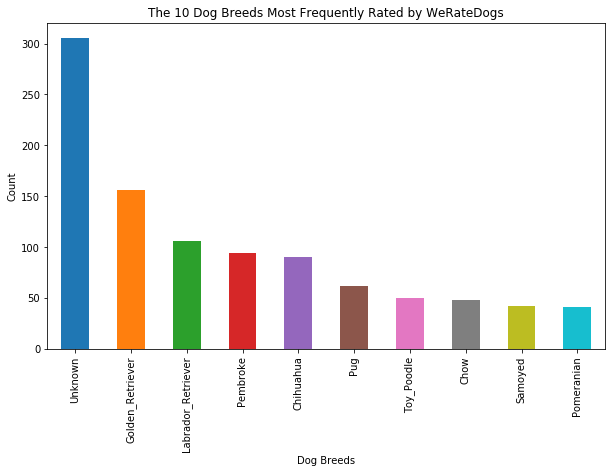

In [60]:
#creating bar graph showing the top 10 most frequently rated dog breeds
top_breeds.plot(kind='bar', figsize=(10, 6))
plt.title('The 10 Dog Breeds Most Frequently Rated by WeRateDogs')
plt.xlabel('Dog Breeds')
plt.ylabel('Count')
#saving figure to be added to the report later
plt.savefig('dog_breed_chart.png');

As you can see, the most frequently rated dog breed by far is 'Unknown'. This could be for a number of reasons. For one, these dogs might be mixed breeds and would not be able to fall into one breed catagory. Another is the quality of image might have made it difficult for the neural network to identify the breed. 

The next most frequent dog breed is a Golden Retriever, followed by Labrador Retrievers. 

### Insight #3

In [61]:
fav_breed = df.groupby('breed')['retweet_count'].sum().reset_index()

In [62]:
top_10 = fav_breed.sort_values(by='retweet_count', ascending=False).head(10)

top_10

,breed,retweet_count
105,Unknown,765990
45,Golden_Retriever,586657
62,Labrador_Retriever,405404
80,Pembroke,291771
27,Chihuahua,250722
88,Samoyed,203446
41,French_Bulldog,156230
30,Cocker_Spaniel,145743
28,Chow,131025
82,Pug,118682


This shows the top 10 dog breeds whose pictures are reshared most frequently in the form of retweets. We once again see that 'Unknown' is very popular, followed by Golden Retrievers and Labrador Retrievers.